<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-MVC-project-description" data-toc-modified-id="1.-MVC-project-description-1">1. MVC project description</a></span></li><li><span><a href="#2.-Setup" data-toc-modified-id="2.-Setup-2">2. Setup</a></span></li><li><span><a href="#3.-Load-the-data" data-toc-modified-id="3.-Load-the-data-3">3. Load the data</a></span></li><li><span><a href="#4.-Configurations" data-toc-modified-id="4.-Configurations-4">4. Configurations</a></span></li><li><span><a href="#5.-Split-the-data" data-toc-modified-id="5.-Split-the-data-5">5. Split the data</a></span></li><li><span><a href="#6.-Pipeline" data-toc-modified-id="6.-Pipeline-6">6. Pipeline</a></span><ul class="toc-item"><li><span><a href="#6.1.-Temporary-step:-normalize-data" data-toc-modified-id="6.1.-Temporary-step:-normalize-data-6.1">6.1. Temporary step: normalize data</a></span></li><li><span><a href="#6.2.-Assembling-the-pipeline" data-toc-modified-id="6.2.-Assembling-the-pipeline-6.2">6.2. Assembling the pipeline</a></span></li><li><span><a href="#6.3.-Define-our-metric" data-toc-modified-id="6.3.-Define-our-metric-6.3">6.3. Define our metric</a></span></li><li><span><a href="#6.4.-Fit-the-pipeline" data-toc-modified-id="6.4.-Fit-the-pipeline-6.4">6.4. Fit the pipeline</a></span></li><li><span><a href="#6.5.-Save-the-model" data-toc-modified-id="6.5.-Save-the-model-6.5">6.5. Save the model</a></span></li></ul></li><li><span><a href="#7.-Learning-curves" data-toc-modified-id="7.-Learning-curves-7">7. Learning curves</a></span></li><li><span><a href="#8.-Evaluation" data-toc-modified-id="8.-Evaluation-8">8. Evaluation</a></span><ul class="toc-item"><li><span><a href="#8.1.-Prediction" data-toc-modified-id="8.1.-Prediction-8.1">8.1. Prediction</a></span></li><li><span><a href="#8.2.-Denormalize-data" data-toc-modified-id="8.2.-Denormalize-data-8.2">8.2. Denormalize data</a></span></li><li><span><a href="#8.3.-Evaluate-on-all-muscles" data-toc-modified-id="8.3.-Evaluate-on-all-muscles-8.3">8.3. Evaluate on all muscles</a></span></li><li><span><a href="#8.4.-Evaluate-on-each-muscle" data-toc-modified-id="8.4.-Evaluate-on-each-muscle-8.4">8.4. Evaluate on each muscle</a></span></li></ul></li><li><span><a href="#9.-Summary" data-toc-modified-id="9.-Summary-9">9. Summary</a></span></li></ul></div>

# 1. MVC project description

**Links**
- [github repo](https://github.com/romainmartinez/mvc)
- [plotly figures](https://plot.ly/organize/romainmartinez:114)

**Author**: _Romain Martinez._

# 2. Setup

In [1]:
# Common imports
import pandas as pd
import numpy as np

# custom functions
import mvc
%load_ext autoreload
%autoreload 2

# Path
from pathlib import Path
PROJECT_PATH = Path('./')
DATA_PATH = PROJECT_PATH / 'data'
MODEL_PATH = PROJECT_PATH / 'model'

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Figures
OFFLINE = True
if OFFLINE:
    import plotly.offline as py
    py.init_notebook_mode(connected=True)
else:
    import plotly.plotly as py

import dill as pickle

# 3. Load the data

In [2]:
df_wide = pd.read_feather(DATA_PATH / 'df_wide')

with open(MODEL_PATH / 'conf.pkl', 'rb') as h:
    conf = pickle.load(h)

# 4. Configurations

In [3]:
conf.update({
    'TEST_COLS': ['3', '4', '5'],
    'CATEGORICAL_COLS': ['muscle'],
    'TEST_REF': ['4']
})

# 5. Split the data

In [4]:
X, y, COL_NAMES, nan_idx = mvc.ml.get_X_and_y(
    df_wide,
    test_col_str=conf['TEST_COLS'],
    other_col_to_keep=conf['CATEGORICAL_COLS'],
    remove_nans=True)

Removed 3 rows


/home/romain/Documents/codes/mvc/mvc/ml.py:5: RuntimeWarning:

All-NaN axis encountered



In [5]:
from sklearn.model_selection import train_test_split

X_indices = np.arange(X.shape[0])

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, X_indices, test_size=0.2, random_state=RANDOM_SEED, stratify=X[:, 0])

conf.update({
    'INDICES_TRAIN': indices_train.tolist(),
    'INDICES_TEST': indices_test.tolist(),
    'NAN_IDX': np.argwhere(nan_idx).flatten().tolist(),
    'COL_NAMES': COL_NAMES
})

# 6. Pipeline

## 6.1. Temporary step: normalize data
This step needs to be temporary out of the pipeline because scikit-learn doesn't have the [TransformedTargetRegressor](http://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.TransformedTargetRegressor.html#sklearn.preprocessing.TransformedTargetRegressor) yet.

In [6]:
to_normalize = np.in1d(conf['COL_NAMES'], conf['TEST_COLS'])
ref = np.in1d(conf['COL_NAMES'], conf['TEST_REF'])

# normalize train set
normalizer_train = mvc.ml.Normalize(to_normalize, ref)
X_train, y_train = normalizer_train.transform(X_train, y_train)

# normalize test set
normalizer_test = mvc.ml.Normalize(to_normalize, ref)
X_test, y_test = normalizer_test.transform(X_test, y_test)

## 6.2. Assembling the pipeline

In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor


def get_categorical_cols(X, ref=conf):
    return X[:, np.in1d(ref['COL_NAMES'], ref['CATEGORICAL_COLS'])]


def get_numerical_cols(X, ref=conf):
    return X[:, np.in1d(ref['COL_NAMES'], ref['TEST_COLS'])]

conf.update({
    'get_categorical_cols': get_categorical_cols,
    'get_numerical_cols': get_numerical_cols
})

pipeline_categorical = Pipeline([
    ('selector', FunctionTransformer(conf['get_categorical_cols'], validate=False)),
    ('encoder', OneHotEncoder(sparse=False))
])

pipeline_numerical = Pipeline([
    ('selector', FunctionTransformer(conf['get_numerical_cols'], validate=False))
])

pipeline_preprocessing = FeatureUnion([('categorical', pipeline_categorical),
                                       ('numerical', pipeline_numerical)])

model_param = dict(
    alpha=0.85,
    learning_rate=0.1,
    loss="ls",
    max_depth=10,
    max_features=1.0,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    subsample=0.55)

pipeline_full = Pipeline([('preprocessing', pipeline_preprocessing),
                          ('regressor',
                           GradientBoostingRegressor(**model_param))])

## 6.3. Define our metric

In [8]:
from sklearn.metrics import make_scorer


def mape(y_test, y_pred):
    val = (np.abs((y_test - y_pred) / y_test)) * 100
    return np.mean(val)


mape_scorer = make_scorer(mape, greater_is_better=False)

print_results = lambda title, toprint: print(f'{title}\n{"-" * 10}\n{toprint}\n')

## 6.4. Fit the pipeline

In [9]:
pipeline_full.fit(X_train, y_train)

/home/romain/miniconda3/envs/mvc/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



Pipeline(memory=None,
     steps=[('preprocessing', FeatureUnion(n_jobs=None,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function get_categorical_cols at 0x7ff2a1e72b70>,
          inv_kw_args=None, invers...ne, subsample=0.55, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))])

In [10]:
y_pred = pipeline_full.predict(X_test)

In [11]:
from sklearn.model_selection import cross_val_score

# evaluate
cv_score = cross_val_score(
    pipeline_full,
    X_train,
    y_train,
    cv=5,
    scoring=mape_scorer)

print_results(title='cv score', toprint=cv_score)
print_results(title='mean', toprint=np.mean(cv_score))

/home/romain/miniconda3/envs/mvc/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.

/home/romain/miniconda3/envs/mvc/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you

cv score
----------
[-0.77219985 -0.41246863 -0.85420844 -0.76483723 -0.39294161]

mean
----------
-0.6393311491457511



/home/romain/miniconda3/envs/mvc/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



## 6.5. Save the model

In [12]:
if not (MODEL_PATH / 'model').is_file():
    from sklearn.externals import joblib
    joblib.dump(pipeline_full, MODEL_PATH / 'model.pkl')

    with open(MODEL_PATH / 'conf.pkl', 'wb') as h:
        pickle.dump(conf, h)

# 7. Learning curves

In [13]:
learning_curves = mvc.plot.learning_curve(
    estimator=pipeline_full,
    X=X_train,
    y=y_train,
    scoring=mape_scorer,
    cv=5,
    train_sizes=np.linspace(.1, 1.0, 10),
    n_jobs=-1,
    random_state=RANDOM_SEED,
    title='Learning curves',
    xtitle='Training examples',
    ytitle='MAPE (%)')

py.iplot(learning_curves, filename='mvc/learning_curves')

AttributeError: module 'mvc' has no attribute 'plot'

# 8. Evaluation

## 8.1. Prediction

In [14]:
y_pred = pipeline_full.predict(X_test)

## 8.2. Denormalize data

In [15]:
_, y_pred_denorm = normalizer_test.inverse_transform(X_test, y_pred)
_, y_test_denorm = normalizer_test.inverse_transform(X_test, y_test)

## 8.3. Evaluate on all muscles

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score


def regression_report(y_test, y_pred, verbose=True):
    report = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mape': mape(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'variance': explained_variance_score(y_test, y_pred)
    }
    if verbose:
        print_results(title='RMSE', toprint=report["rmse"])
        print_results(title='MAPE', toprint=report["mape"])
        print_results(title='R2', toprint=report["r2"])
        print_results(title='variance', toprint=report["variance"])
    return report

In [17]:
report = {}
report['mean'] = regression_report(y_test_denorm,  y_pred_denorm)

RMSE
----------
0.0016135468892768086

MAPE
----------
0.498738448171074

R2
----------
0.9999098153500995

variance
----------
0.9999098885683321



In [26]:
pd.DataFrame(X_train).to_csv("X_train.csv", index=False)
pd.Series(y_train).to_csv("y_train.csv", index=False)
pd.DataFrame(X_test).to_csv("X_test.csv", index=False)
pd.Series(y_test).to_csv("y_test.csv", index=False)


## 8.4. Evaluate on each muscle

In [18]:
col_muscle = np.in1d(COL_NAMES, conf['CATEGORICAL_COLS'])
for imuscle in np.unique(X_test[:, col_muscle]).astype(int):
    subset = (X_test[:, col_muscle] == imuscle).ravel()
    report[imuscle] = regression_report(
        y_test_denorm[subset], y_pred_denorm[subset], verbose=False)

report_by_muscle = pd.DataFrame(report).T.drop('mean', axis=0)
report_by_muscle.index = conf['MUSCLES']

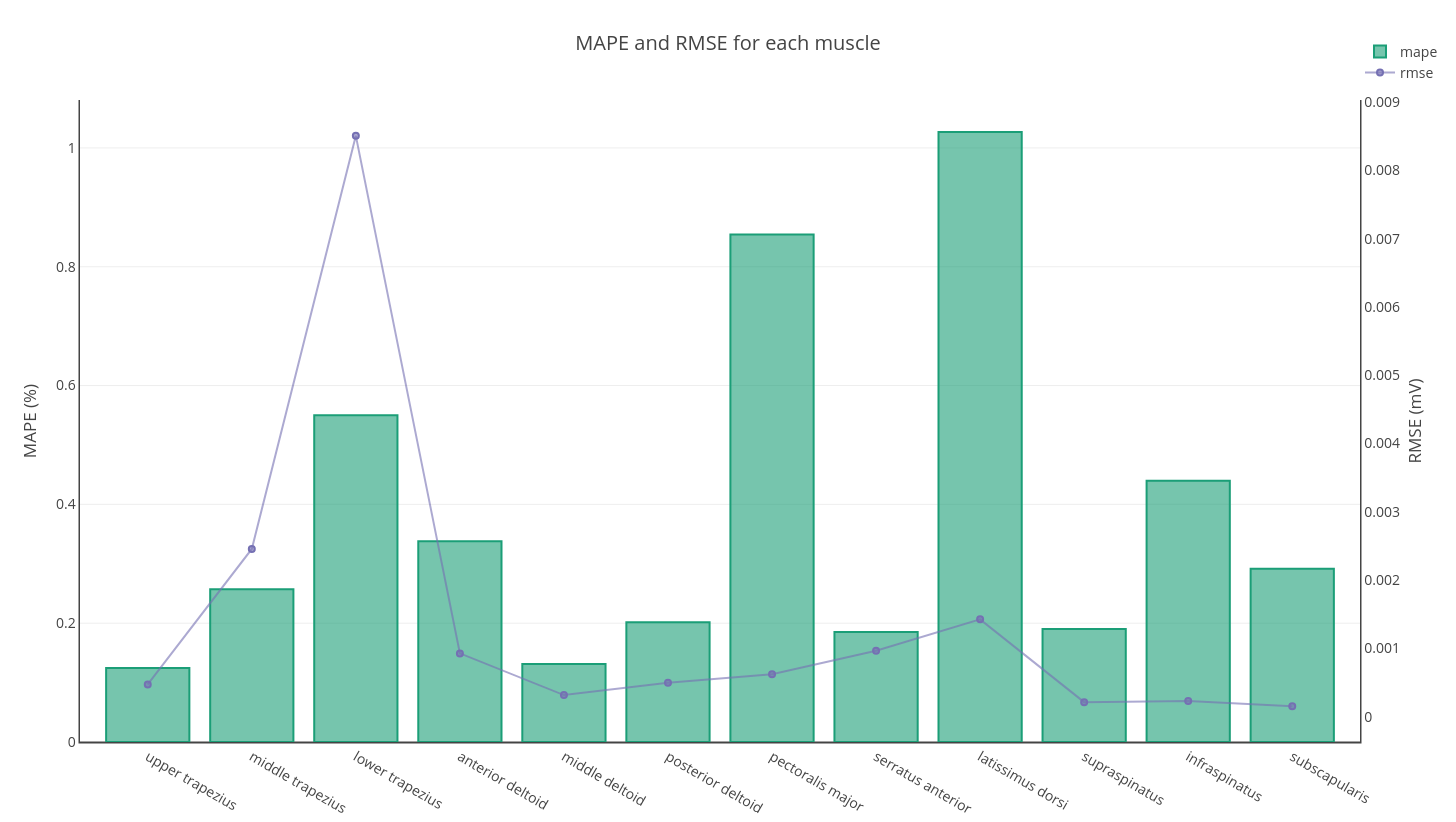

In [19]:
metrics_by_muscle = mvc.plot.bar_metrics(
    report_by_muscle,
    title='MAPE and RMSE for each muscle',
    ytitle='MAPE (%)',
    y2title='RMSE (mV)')
py.iplot(metrics_by_muscle, filename='mvc/metrics_by_muscle')

# 9. Summary

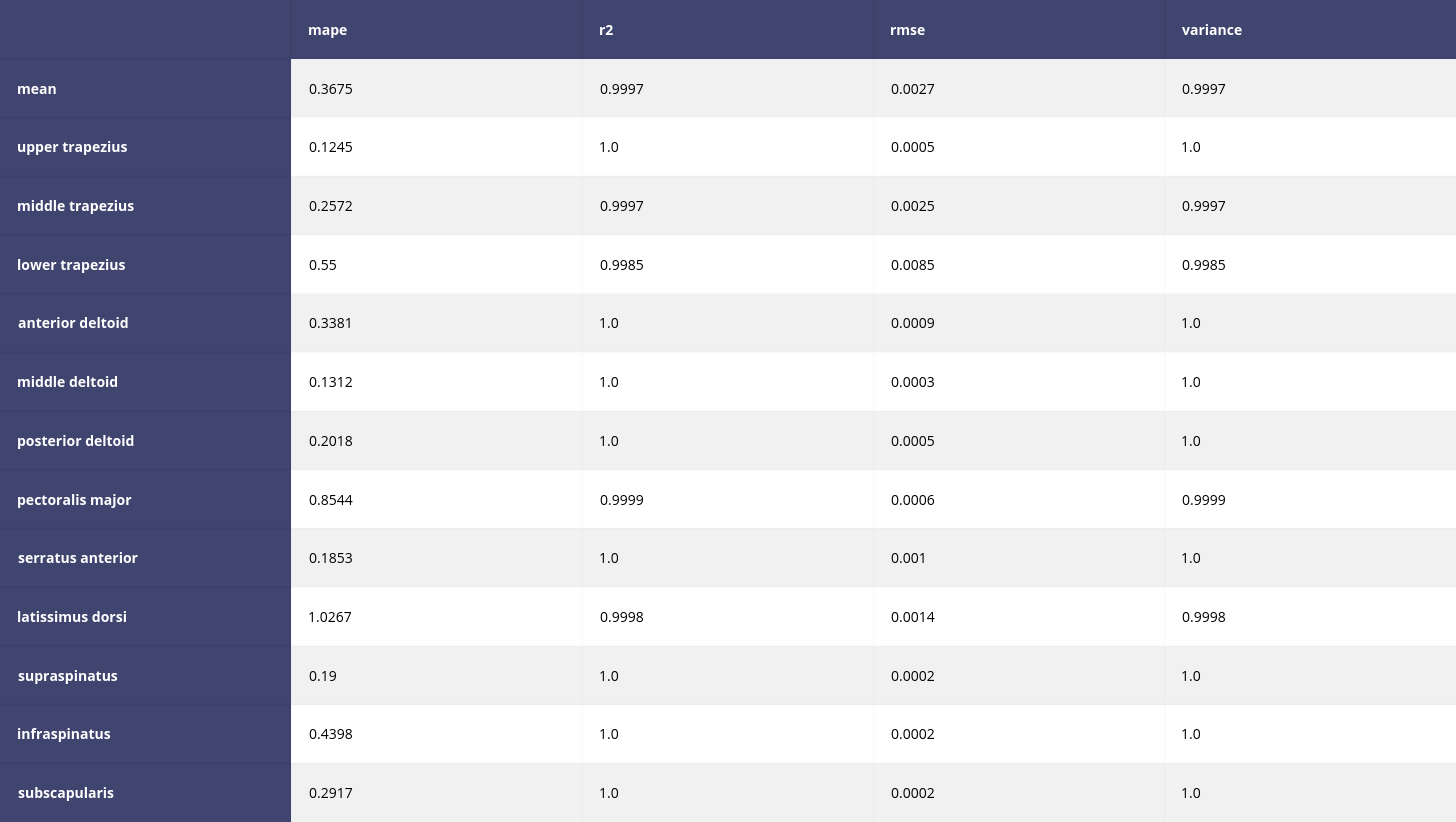

In [20]:
summary_report = pd.DataFrame(report).T
summary_report.index = ['mean'] + conf['MUSCLES']

table_report = mvc.plot.regression_report(np.round(summary_report, decimals=4))
py.iplot(table_report, filename='mvc/table_report')